Here we load all the packages used in this project

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt

### **Step 1: Select S&P500 Dataset**

We download the S&P index dataset, and we download the Schiller P/E ratio data. We choose to analyze data from 01/01/1960 to 12/21/2018. We print the head and tail of the two datasets to understand their data structure.

In [2]:
url = 'https://raw.githubusercontent.com/troyin/RNN/main/sp500.csv'
df1 = pd.read_csv(url)

df1['Date'] = df1['Date'].astype('datetime64[ns]')
df1 = df1.loc[(df1['Date'] > '1960-01-01')]
print(df1.tail(5))
url = 'https://raw.githubusercontent.com/troyin/RNN/main/pe_ratio_.csv'
df2 = pd.read_csv(url)
df2['Date'] = df2['Date'].astype('datetime64[ns]')
print(df2.head(5))

          id       Date     Open     High      Low    Close  Adj Close  \
17351  17352 2018-12-17  2590.75  2601.13  2530.54  2545.94    2545.94   
17352  17353 2018-12-18  2559.90  2573.99  2528.71  2546.16    2546.16   
17353  17354 2018-12-19  2547.05  2585.29  2488.96  2506.96    2506.96   
17354  17355 2018-12-20  2496.77  2509.63  2441.18  2467.42    2467.42   
17355  17356 2018-12-21  2465.38  2504.41  2408.55  2416.62    2416.62   

           Volume  
17351  4616350000  
17352  4470880000  
17353  5127940000  
17354  5585780000  
17355  7609010000  
        Date  PE RATIO
0 1960-01-01     18.34
1 1960-02-01     17.55
2 1960-03-01     17.29
3 1960-04-01     17.43
4 1960-05-01     17.26


We overlay the two datasets to observe if the time trends for S&P 500 index and P/E ratio are correlated. The two lines do not appear to indicate a strong temporal correlation.

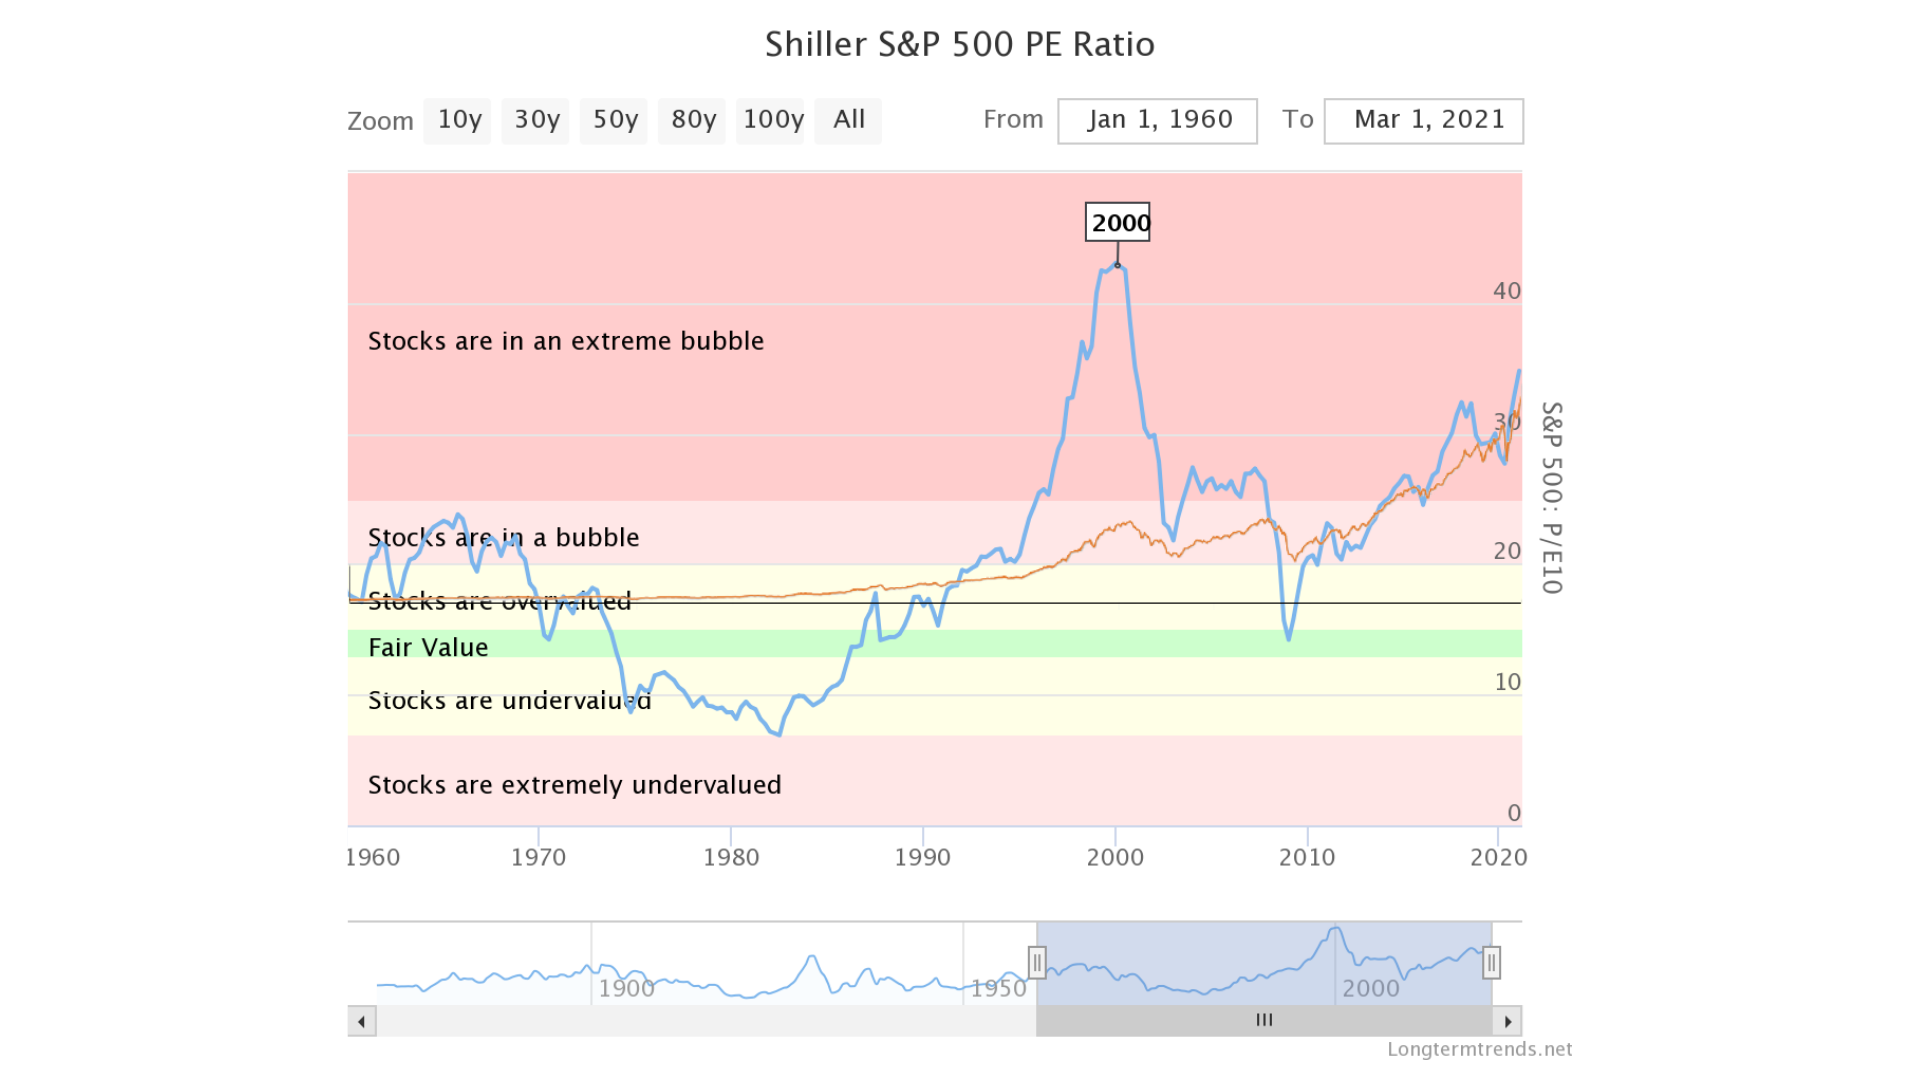

We construct a new data frame by merging the two datasets. We only keep the *closing price* of the S&P index for analysis, which will be the value to be predicted from the RNN model.

In [4]:
df = pd.merge(df1.assign(grouper=df1['Date'].dt.to_period('M')),
               df2.assign(grouper=df2['Date'].dt.to_period('M')),
               how='left', on='grouper')[['Date_x','Close','PE RATIO']]
print(df)

          Date_x    Close  PE RATIO
0     1960-01-04    59.91     18.34
1     1960-01-05    60.39     18.34
2     1960-01-06    60.13     18.34
3     1960-01-07    59.69     18.34
4     1960-01-08    59.50     18.34
...          ...      ...       ...
14840 2018-12-17  2545.94     28.29
14841 2018-12-18  2546.16     28.29
14842 2018-12-19  2506.96     28.29
14843 2018-12-20  2467.42     28.29
14844 2018-12-21  2416.62     28.29

[14845 rows x 3 columns]


We define the training set and test set to be used for building the Recurrent Neural Net.


*   The training set contains the whole dataset.

*   The test set contains data points after 1980-01-01.



In [5]:
training_set = df[['Close','PE RATIO']].values
test_set = df.loc[(df['Date_x'] > '1980-01-01')][['Close','PE RATIO']].values

We apply the MinMaxScaler function in the sklearn package to normalize the training dataset into numbers between zero and one. Normalization is changing the values of numeric columns in the dataset to a common scale, which helps the performance of our model. 

In [6]:
from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = mmsc.fit_transform(training_set)


We overlay the standardized values of the S&P index closing price and the P/E ratio to visualize their respective time trends. We can see that after normalization, the correlation between S&P index closing price and the P/E ratio appears to be stronger than before.

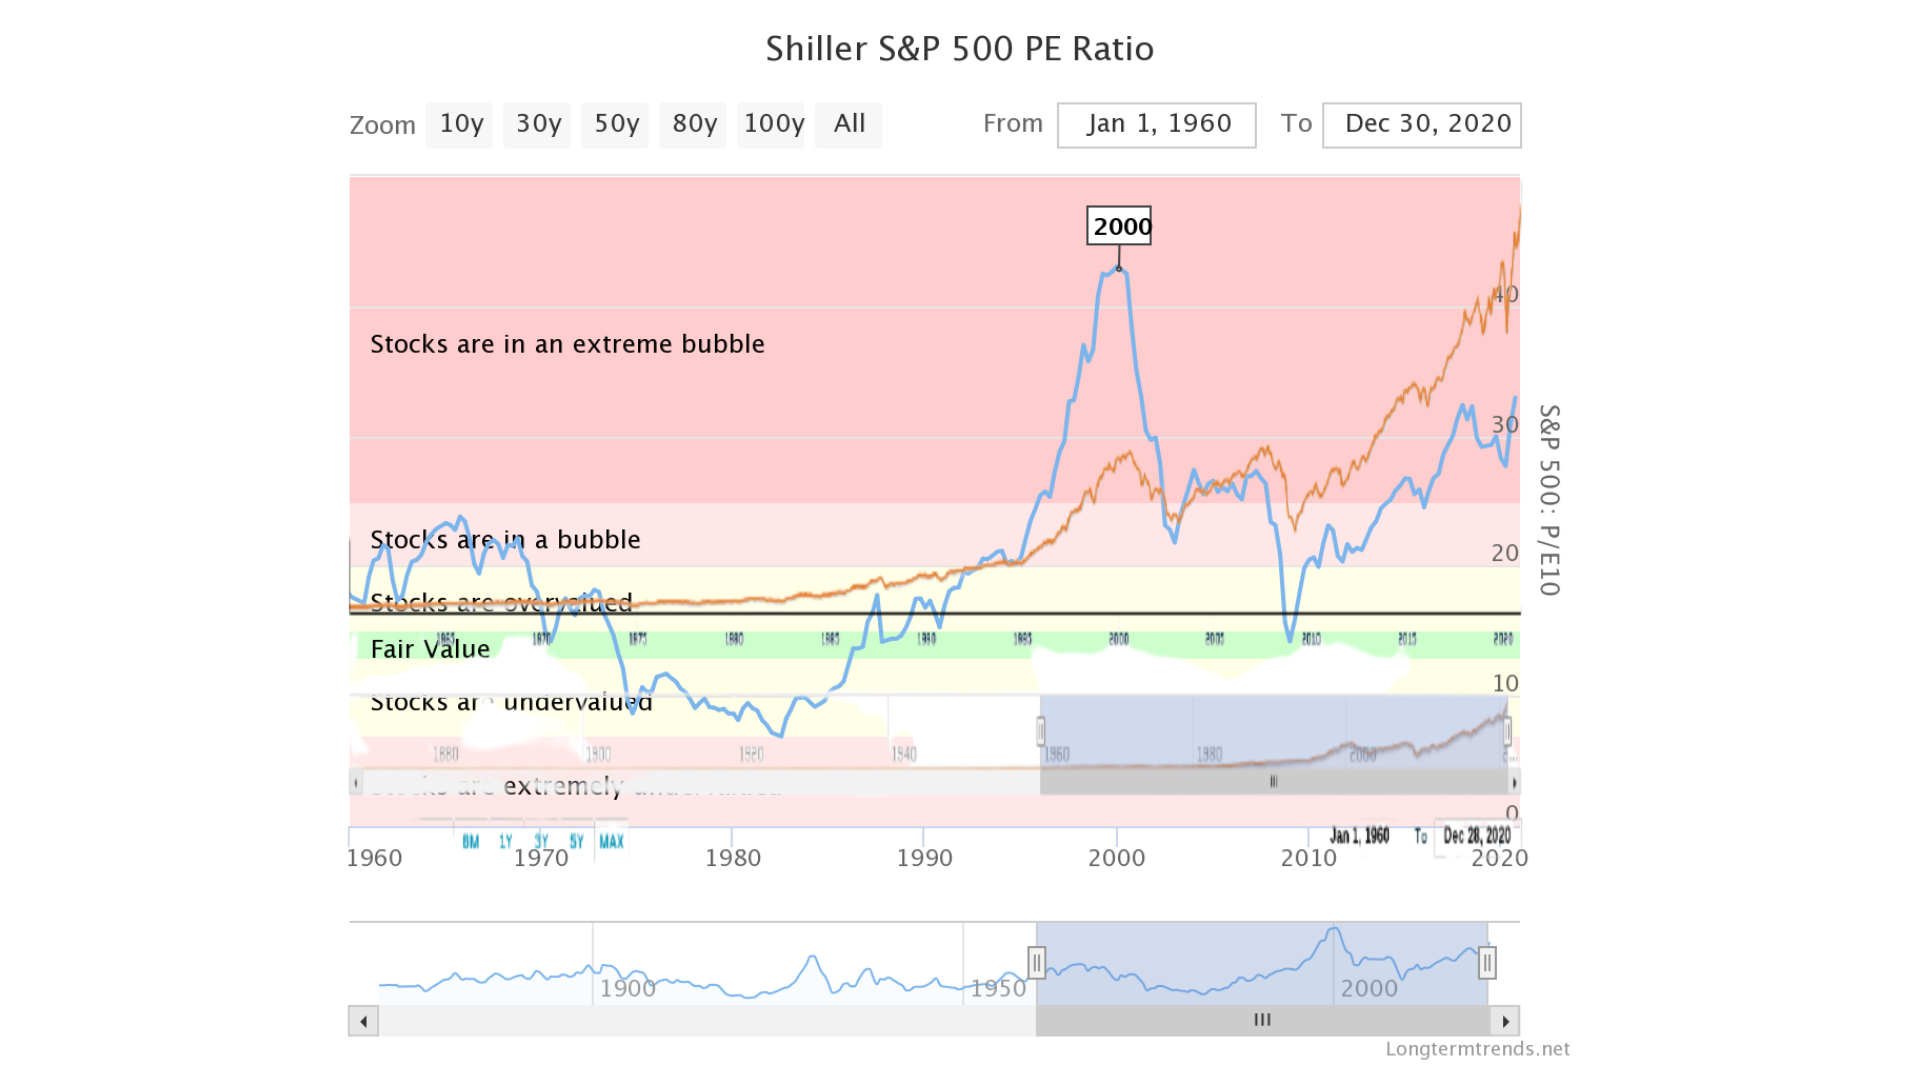

### Step 2 & 3: Design, develop, and train a recurrent neural network (RNN) 

We plan to build a long short-term memory (LSTM) model, an improved version of RNNs. We need to input the data in the form of a 3D array to the LSTM model. We thus separate the training set into x_train and y_train. x_train will contain the input features, and y_train will contain the values to be predicted from the model. 
* We make x_train as a 3D array with the following shape: 14662 data points, 180 timesteps (we will use a sliding sampling window of width 180 days for the prediction), and 2 features (i.e., closing price and P/E ratio). 
* y_train is a 2D array with the following shape: 14662 data points, and 4 columns that store the values to be predicted. The first column is the next value (i.e., closing price) following the 180 sample points, the second column is the second next value, the third column is the third next value, and the fourth column is the fourth next value.

In [7]:
x_train = []
y_train = []
for i in range(180, df.shape[0]-3 ):
    x_train.append(training_set_scaled[i-180:i, 0:2])
    y_train.append(training_set_scaled[i:(i+4),0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(14662, 180, 2)
(14662, 4)


We design the LSTM model and train the model. 
* The model has three hidden LSTM layers, which are separated by two Dropout layers. The dropout layer is added to prevent overfitting.
* The LSTM layers have the following arguments: 50 units is the dimensionality of the output space, return_sequences=True is necessary for stacking LSTM layers so the consequent LSTM layer has a three-dimensional sequence input, and input_shape is the shape of the training dataset as defined above.
* The dropout layer has a hyperparameter of 0.2, which means that 20% of the layers will be dropped.
* A Dense layer is added after the LSTM and Dropout layers. This layer specifies an output of four units, which correspond to the four data points to be predicted. 
* We use the adam optimizer to compile the model 
* We set mean squared error as the loss function. 
* Finally, we use EarlyStopping to determine the exact number of epochs, which are the number of times the learning algorithm will work through the entire dataset. 

In [16]:
model = keras.Sequential()
model.add(tf.keras.layers.LSTM(50,return_sequences=True, input_shape=(180, 2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(4))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.fit(x_train, y_train, epochs = 100, callbacks=[stop_early])

Epoch 1/100
459/459 [==============================] - 40s 88ms/step - loss: 0.0020
Epoch 2/100
459/459 [==============================] - 42s 91ms/step - loss: 2.7254e-04
Epoch 3/100
459/459 [==============================] - 42s 91ms/step - loss: 2.1035e-04
Epoch 4/100
459/459 [==============================] - 42s 92ms/step - loss: 1.9116e-04
Epoch 5/100
459/459 [==============================] - 42s 92ms/step - loss: 1.6321e-04 4s 
Epoch 6/100
459/459 [==============================] - 42s 92ms/step - loss: 1.8004e-04
Epoch 7/100
459/459 [==============================] - 43s 94ms/step - loss: 1.5448e-04
Epoch 8/100
459/459 [==============================] - 43s 93ms/step - loss: 1.5729e-04  - ETA: 0s - loss:
Epoch 9/100
459/459 [==============================] - 43s 94ms/step - loss: 1.5120e-04
Epoch 10/100
459/459 [==============================] - 43s 95ms/step - loss: 1.3520e-04
Epoch 11/100
459/459 [==============================] - 43s 94ms/step - loss: 1.4069e-04 1
Epoch 12/

Below we provide a model summary to show the LSTM model architecture. 
* It shows the output shape for each hidden layer and the number of parameters between two successive layers.

* The total parameters trained in our model is 51,204.

In [17]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 180, 50)           10600     
_________________________________________________________________
dropout_6 (Dropout)          (None, 180, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 180, 50)           20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 180, 50)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 204       
Total params: 51,204
Trainable params: 51,204
Non-trainable params: 0
__________________________________________________

### Step 4: Test the recurrent neural network (RNN)

We create a second MinMaxScaler in order to transform predictions to original scale. 

In [18]:
mmsc2 = MinMaxScaler(feature_range = (0, 1)).fit(training_set[:,0:1])

We write a function to have the RNN model to predict closing prices for the next four data points (i.e., the four dates following the sampling window).

In [19]:
def get_predictions(test_set,noise_lvl, model):
  test_set_scaled = mmsc.fit_transform(test_set)
  x_test = []
  y_test = []

  for i in range(180, test_set.shape[0]-3 ):
     x_test.append(test_set_scaled[i-180:i, 0:2])
     y_test.append(test_set_scaled[i:(i+4),0])
    
  noise = np.random.normal(0,noise_lvl,(180,2))
  indices = np.random.choice(360, replace=False, size=int(360 * 0.9))
  noise.reshape(-1)[indices]=0
  x_test_noise = x_test.copy()
  for i in range(len(x_test)):
    x_test_noise[i] = x_test_noise[i] + noise


  x_test_noise, y_test = np.array( x_test_noise), np.array(y_test)
  predict = model.predict(x_test_noise)
  predict_original= mmsc2.inverse_transform(predict)
  y_test_original=  mmsc2.inverse_transform(y_test)
  df_1day =pd.DataFrame({'Date':df.loc[(df['Date_x'] > '1980-01-01')][['Date_x']].values[180:(-3)].ravel(), 'Value': y_test_original[:,0], 'Prediction': predict_original[:,0]})
  df_2day =pd.DataFrame({'Date':df.loc[(df['Date_x'] > '1980-01-01')][['Date_x']].values[181:(-2)].ravel(), 'Value': y_test_original[:,1], 'Prediction': predict_original[:,1]})
  df_3day =pd.DataFrame({'Date':df.loc[(df['Date_x'] > '1980-01-01')][['Date_x']].values[182:(-1)].ravel(), 'Value': y_test_original[:,2], 'Prediction': predict_original[:,2]})
  df_4day =pd.DataFrame({'Date':df.loc[(df['Date_x'] > '1980-01-01')][['Date_x']].values[183:].ravel(), 'Value': y_test_original[:,3], 'Prediction': predict_original[:,3]})
  return df_1day, df_2day, df_3day,df_4day

We test the accuracy of the RNN in predicting the next one, two, three, and four data points.

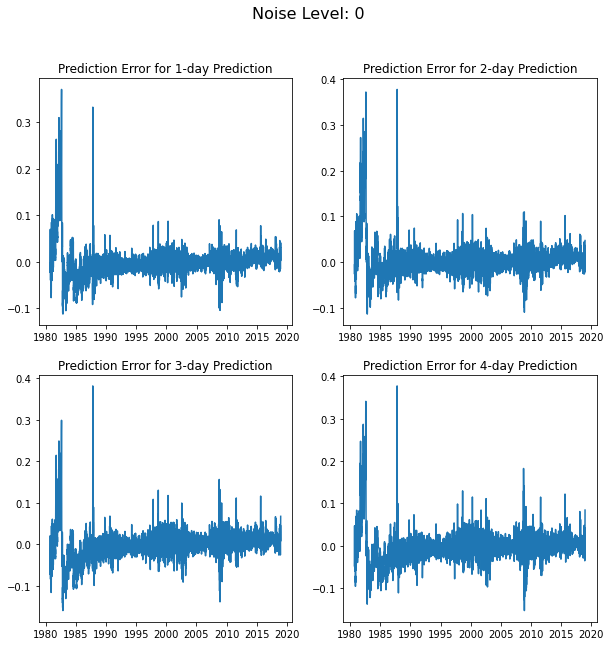

In [23]:
df_1day, df_2day, df_3day, df_4day = get_predictions(test_set,0, model)
fig, axarr = plt.subplots(2, 2)
fig.suptitle("Noise Level: 0", fontsize=16)

axarr[0, 0].plot(df_1day.Date, (df_1day.Prediction-df_1day.Value)/df_1day.Value)
axarr[0, 0].set_title('Prediction Error for 1-day Prediction')
axarr[0, 1].plot(df_2day.Date, (df_2day.Prediction-df_2day.Value)/df_2day.Value)
axarr[0, 1].set_title('Prediction Error for 2-day Prediction')
axarr[1, 0].plot(df_3day.Date, (df_3day.Prediction-df_3day.Value)/df_3day.Value)
axarr[1, 0].set_title('Prediction Error for 3-day Prediction')
axarr[1, 1].plot(df_4day.Date, (df_4day.Prediction-df_4day.Value)/df_4day.Value)
axarr[1, 1].set_title('Prediction Error for 4-day Prediction')
fig.set_figheight(10)
fig.set_figwidth(10)

### Step 5: Optimize the recurrent neural network (RNN)

Here we impose kerastuner to optimize the LSTM network.

In [ ]:
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization

def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), return_sequences = True,
                input_shape=(180, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), return_sequences = True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32)))
    model.add(tf.keras.layers.Dense(4))
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate',
                  values=[1e-2, 1e-3, 1e-4])))
    return model


tuner = BayesianOptimization(
    model_builder,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory='keras_tuning',
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Since the running takes a lot of time, we just moved the results here:

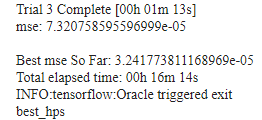

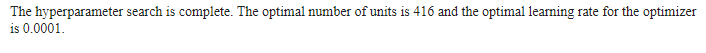

### Step 6: Corrupt the test set by adding noise, and test model performance

We create various noise levels, and we use our RNN to predict the S&P closing price at various noise levels.

In [34]:
noises=[0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1]
prediction_set = {}

for noise in noises:
  prediction_set[noise] = get_predictions(test_set,noise,model)

Here we show the 1-day prediction results when the noise level is lowest (i.e., standard deviation is 0.001).

In [35]:
prediction_set[0.001][0]

,Date,Value,Prediction
0,1980-09-17,83.347969,82.481758
1,1980-09-18,82.870333,82.650154
2,1980-09-19,83.734143,82.811501
3,1980-09-22,84.902827,82.923752
4,1980-09-23,83.917068,83.028992
...,...,...,...
9642,2018-12-12,2646.526050,2653.177490
9643,2018-12-13,2645.987439,2651.420166
9644,2018-12-14,2594.575506,2652.608887
9645,2018-12-17,2539.688008,2643.018066


In [36]:
error_tables=[]
row_names=[]
column_names=[]

for prediction in prediction_set[0.001]:
  row_count=prediction.shape[0]
  arr = np.array([[0.00]*row_count]*9)
  error_tables.append(arr)
  row_name_values = prediction['Date']
  row_names.append(row_name_values)


We write a function that allows us to create a table of prediction error for RNN applied to S&P500 data with noisy input.

In [37]:
def display_error(prediction_set):
  j=0
  for key in prediction_set:
    column_names.append('stddev-'+str(key))
    i=0
    for prediction in prediction_set[key]:
      error_list=[]
      for index,row in prediction.iterrows():
        error = (row['Prediction']-row['Value'])/row['Value']
        error_list.append(error)
      error_tables[i][j]=error_list
      i+=1
    j+=1
  
  for i in range(4):
    disp = pd.DataFrame(data=error_tables[i].T,index=row_names[i],columns=column_names)
    print(disp)

The following function generates the table that shows how prediction error changes when RNN is applied to S&P500 data with various noise levels.

In [38]:
display_error(prediction_set)

            stddev-0.001  stddev-0.002  stddev-0.003  stddev-0.005  \
Date                                                                 
1980-09-17     -0.010393     -0.013485     -0.009180     -0.008884   
1980-09-18     -0.002657     -0.005782     -0.001440     -0.001125   
1980-09-19     -0.011019     -0.014168     -0.009827     -0.009548   
1980-09-22     -0.023310     -0.026465     -0.022141     -0.021831   
1980-09-23     -0.010583     -0.013792     -0.009396     -0.009000   
...                  ...           ...           ...           ...   
2018-12-12      0.002513      0.002042      0.002434      0.004378   
2018-12-13      0.002053      0.001580      0.001977      0.003850   
2018-12-14      0.022367      0.021875      0.022286      0.024154   
2018-12-17      0.040686      0.040175      0.040603      0.042567   
2018-12-18      0.032223      0.031717      0.032144      0.034197   

            stddev-0.01  stddev-0.02  stddev-0.03  stddev-0.05  stddev-0.1  
Date        

We further graph the prediction error as a function of time. 

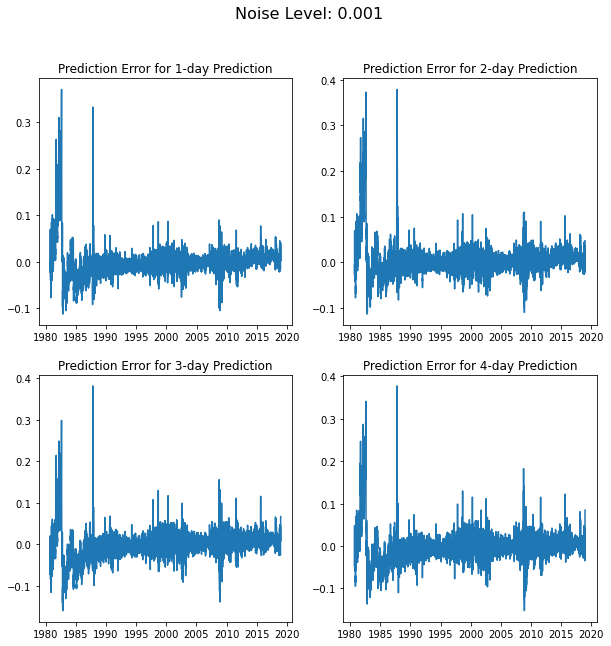

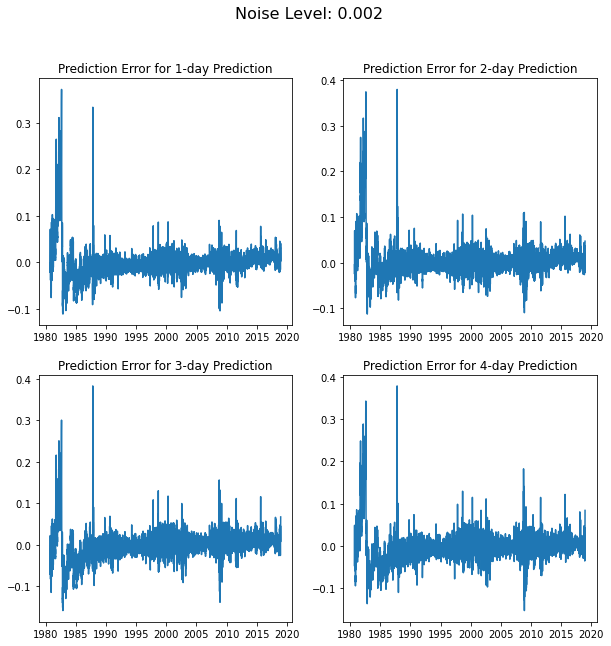

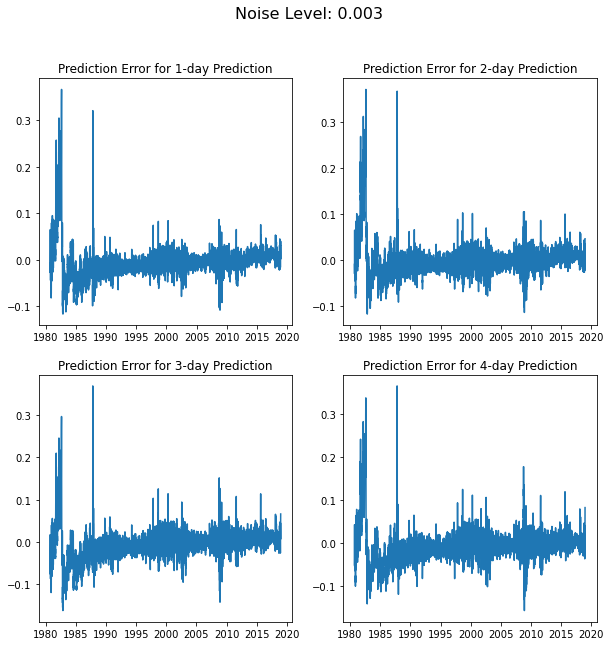

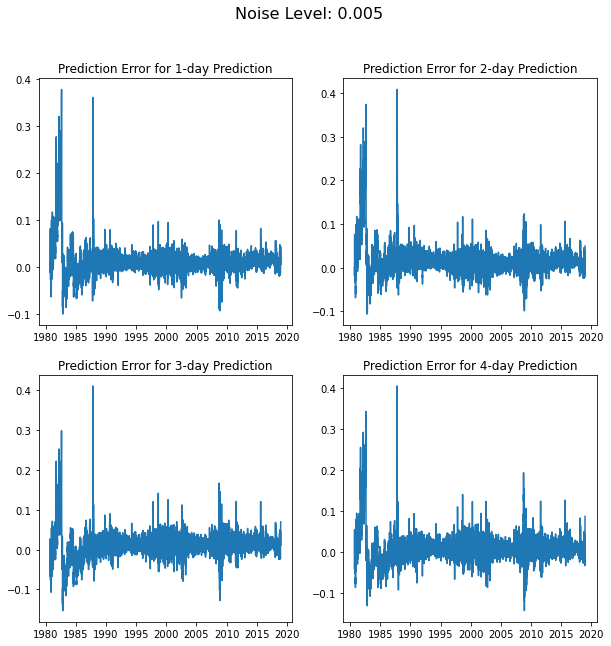

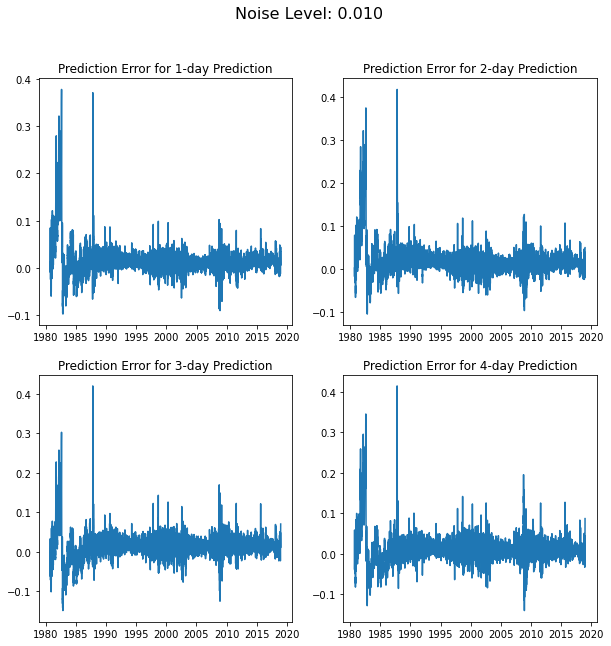

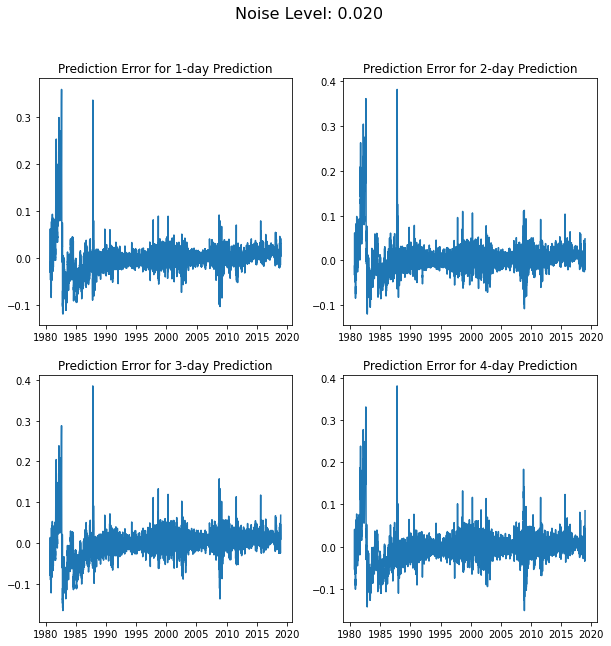

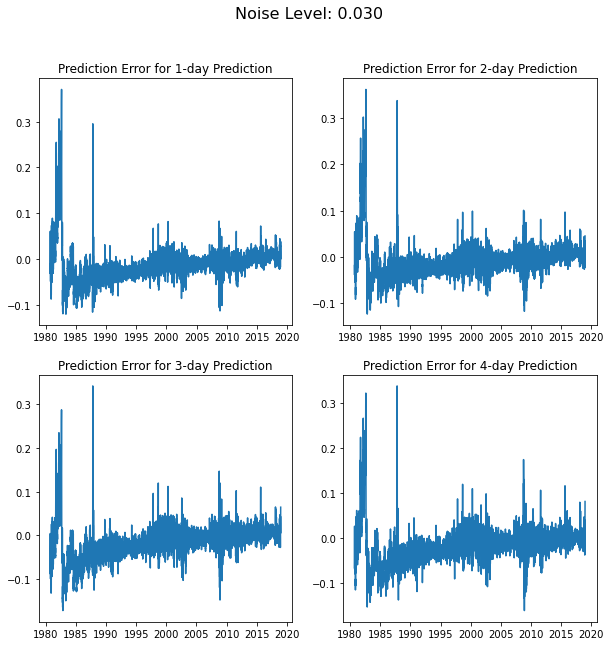

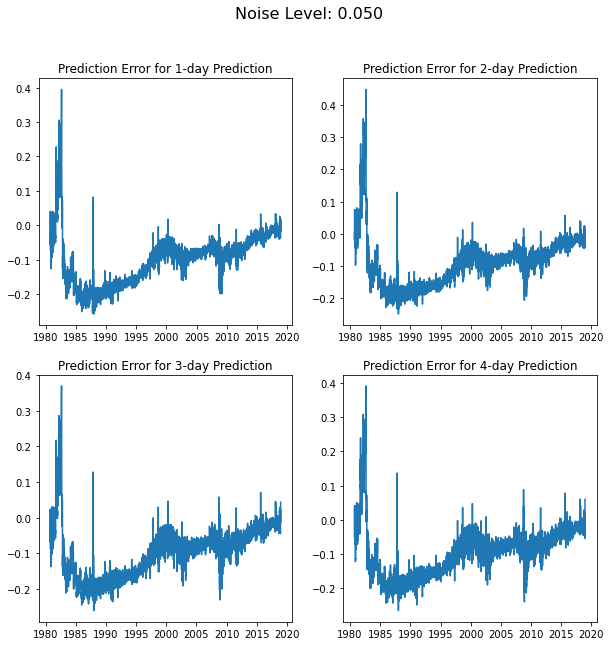

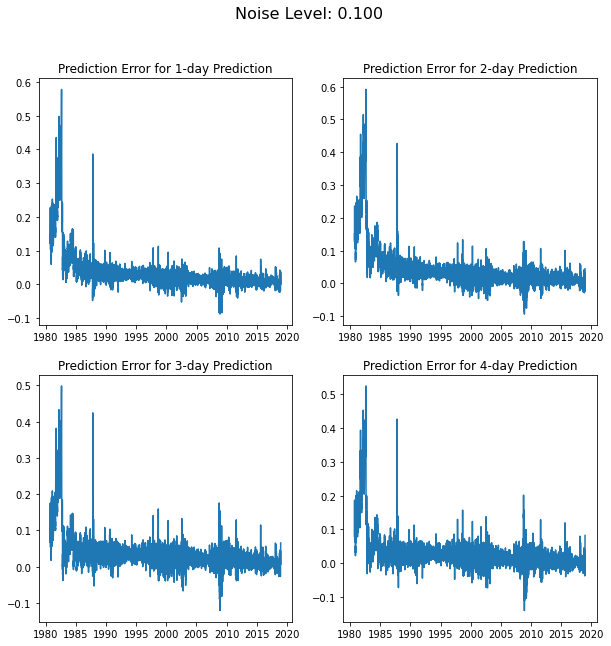

In [39]:
for i in noises:
  df_1day, df_2day, df_3day, df_4day = get_predictions(test_set,i,model)
  fig, axarr = plt.subplots(2, 2)
  fig.suptitle("Noise Level: %1.3f"%i, fontsize=16)

  axarr[0, 0].plot(df_1day.Date, (df_1day.Prediction-df_1day.Value)/df_1day.Value)
  axarr[0, 0].set_title('Prediction Error for 1-day Prediction')
  axarr[0, 1].plot(df_2day.Date, (df_2day.Prediction-df_2day.Value)/df_2day.Value)
  axarr[0, 1].set_title('Prediction Error for 2-day Prediction')
  axarr[1, 0].plot(df_3day.Date, (df_3day.Prediction-df_3day.Value)/df_3day.Value)
  axarr[1, 0].set_title('Prediction Error for 3-day Prediction')
  axarr[1, 1].plot(df_4day.Date, (df_4day.Prediction-df_4day.Value)/df_4day.Value)
  axarr[1, 1].set_title('Prediction Error for 4-day Prediction')
  fig.set_figheight(10)
  fig.set_figwidth(10)

### **Step 7: Discussion**

In this assignment, we have built a LSMT model that uses historical S&P stock price (a 180-day sampling window) and the P/E ratio data to predict the S&P stock price in the next four days. Although the exact closing prices predicted from our LSTM model weren’t always close to the actual price, our model did indicate overall trends such as going up or down.

Accurately predicting the stock price is overall a very challenging task. The market data have a high noise to signal ratio and there are a multitude of factors that affect stock prices. However, to build a model that helps investors make money, our benchmark is 50% accuracy; in other words, as long as we build a model that can predict S&P prices to go up or go down at an accuracy rate above 50%. The LSTM model built by us appears to be capable of passing this benchmark. Of course, before we bet thousands of dollars in the high-risk market with the predictions generated by our LSTM, we will need to test it for an extensive period of time and find ways to better improve the model.

One direction of improvement is to add more predictors such as interest rate, ten-year treasury note yield, and gold prices, factors that are known to be correlated with stock prices. Moreover, we will need to experiement with other LSTM architectures. For instance, we may test model performance by increasing or reducing the cell units in the output space of the LSTM hidden layer and the dropout rate in the Dropout layers. Finally, LSTM is just one type pf RNN that is widely used for predicting temporal trends; we may experiment with other types of RNNs to see if they achieve better model performance than the LSTM.